In [1]:
import networkx as nx
import numpy as np
import pandas as pd 

import community as community_louvain

In [2]:
# for visualization
from IPython.display import SVG 
from sknetwork.visualization import svg_graph 
from sknetwork.data import Bunch 
from sknetwork.ranking import PageRank 
from scipy.sparse import csr_matrix

def draw_graph(G, show_names=False, node_size=1, font_size=10, edge_width=0.5):

    adjacency = nx.to_scipy_sparse_array(G, nodelist=None, dtype=None, weight='weight', format='csr')
    adjacency = csr_matrix(adjacency) # fix to weird sknetwork-csr issue; comment out to troubleshoot
    
    names = np.array(list(G.nodes))
    
    graph = Bunch()
    graph.adjacency = adjacency
    graph.names = np.array(names)
    
    pagerank = PageRank()
    scores = pagerank.fit_transform(adjacency)

    if show_names:
        
        image = svg_graph(graph.adjacency, font_size=font_size, node_size=node_size, names=graph.names, width=700, height=500, scores=scores, edge_width=edge_width)
    
    else:
        
        image = svg_graph(graph.adjacency, node_size=node_size, width=700, height=500, scores = scores, edge_width=edge_width)
    
    return SVG(image)

In [3]:
data = r'data/wilco_edgelist.csv'

df = pd.read_csv(data)

df.head()

,source,target
0,wilco,Wilco
1,wilco,Procedure word
2,wilco,Roger Wilco
3,wilco,Wilco (disambiguation)
4,wilco,Jeff Tweedy


In [4]:
G = nx.from_pandas_edgelist(df)

G.remove_edges_from(nx.selfloop_edges(G))

# use the ego network as the graph (to quickly remove noise) and radius to get to the right place
G = nx.ego_graph(G, 'Wilco', radius=2)

In [6]:
print(G)

Graph with 166 nodes and 377 edges


# Music Discovery using Graph Analysis

In today's analysis, I am looking to discover other musicians and albums I was not aware of. I am a big fan of Wilco, but I stopped keeping up with albums after 2012, so this is my attempt at playing catch-up.

But this follows the larger theme of using networks for knowledge discovery, or information discovery, whatever you want to call it. 

Often, graphs are used as a source of data, but not explored. There are rich insights in any networks, but you must explore. 

# Inspect the Core

One of the first things I always do is inspect the core. It can be useful to do an inspection of the core of any network, to see the different parts that are influencing the network. To do this, I use k_core, and I increase the number until I can go no higher. 

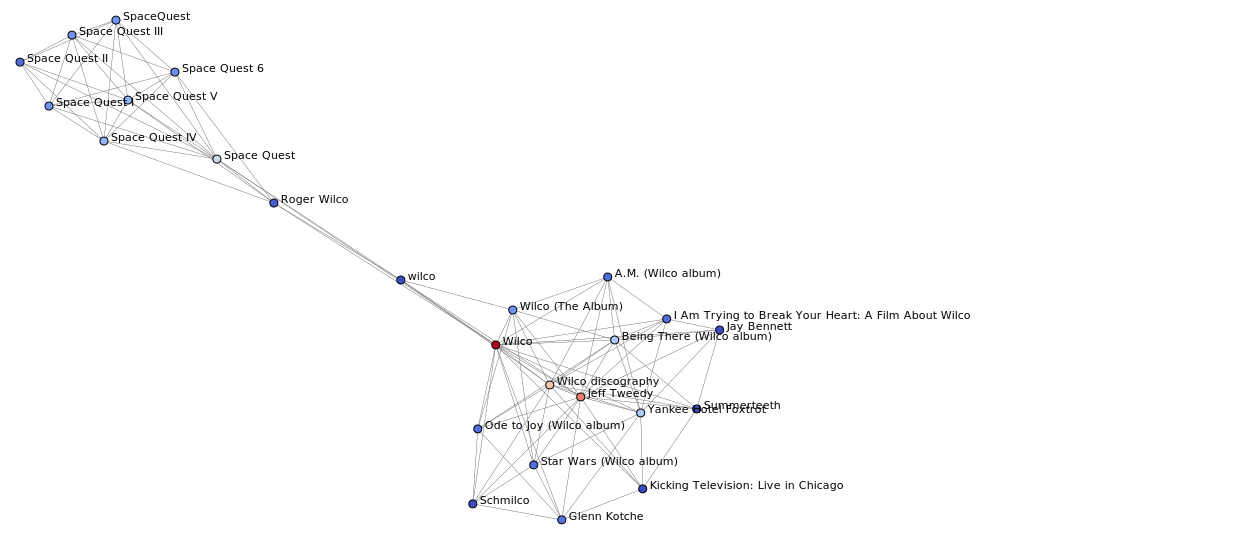

In [7]:
# draw the core

draw_graph(nx.k_core(G, 6), node_size=4, font_size=11, show_names=True, edge_width=0.3)

Now I can see that there are a few parts to this network and that it is not a pure Wilco network. That's normal when using automation to generate network data. It takes exploration to get to the value. Get used to zooming in and out using k_core. It is very useful for this. 

# Identify Nodes of Interest

The next thing I do is identify key nodes of interest. As written about previously, there are ceveral measures and centralities that can be used, such as Page Rank, Betweenness Centrality, Degree Centrality, Closeness Centrality, and on and on. Spend time learning about the different measures of importance. There are very useful.

In [8]:
page_rank = nx.pagerank(G)

pr_df = pd.DataFrame().from_dict(page_rank, orient='index')
pr_df.columns = ['page_rank']
pr_df.sort_values('page_rank', ascending=False, inplace=True)
pr_df.head(10)

,page_rank
Wilco,0.040223
Jeff Tweedy,0.036007
Procedure word,0.021868
Wilco Kelderman,0.021068
Yankee Hotel Foxtrot,0.019813
Wilco discography,0.018422
Glenn Kotche,0.018137
Wilco (disambiguation),0.017826
Billy Bragg,0.017653
Cruel Country,0.017313


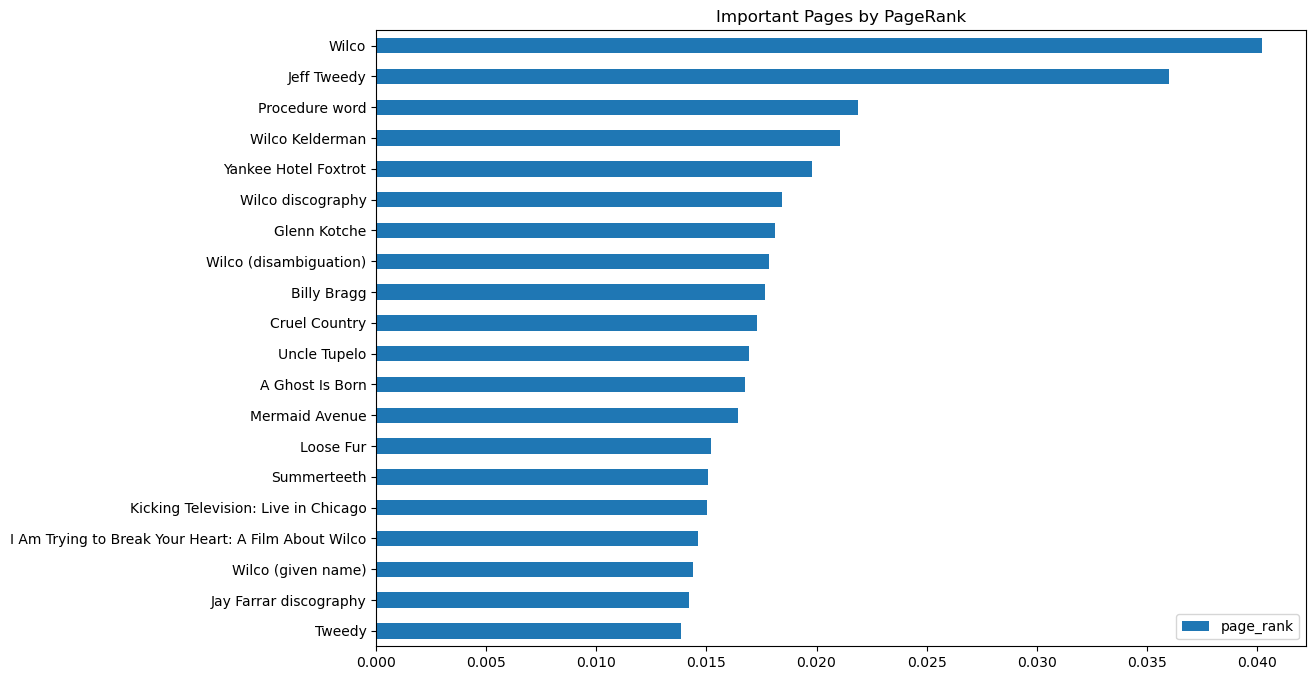

In [9]:
title = 'Important Pages by PageRank'

pr_df.head(20).plot.barh(figsize=(12,8), title=title).invert_yaxis()

This hints at the mixed nature of this network. I can see that Wilco and Jeff Tweedy (lead singer of Wilco) have a drastically higher Page Rank score than the other nodes.

In [10]:
betw_cent = nx.betweenness_centrality(G)

betw_cent_df = pd.DataFrame().from_dict(betw_cent, orient='index')
betw_cent_df.columns = ['betweenness_centrality']
betw_cent_df.sort_values('betweenness_centrality', ascending=False, inplace=True)
betw_cent_df.head(10)

,betweenness_centrality
Wilco,0.548412
Jeff Tweedy,0.157398
Procedure word,0.128628
Wilco Kelderman,0.106282
Space Quest,0.082909
A Ghost Is Born,0.073075
Cruel Country,0.071813
Billy Bragg,0.071160
Loose Fur,0.059985
Wilco (disambiguation),0.057518


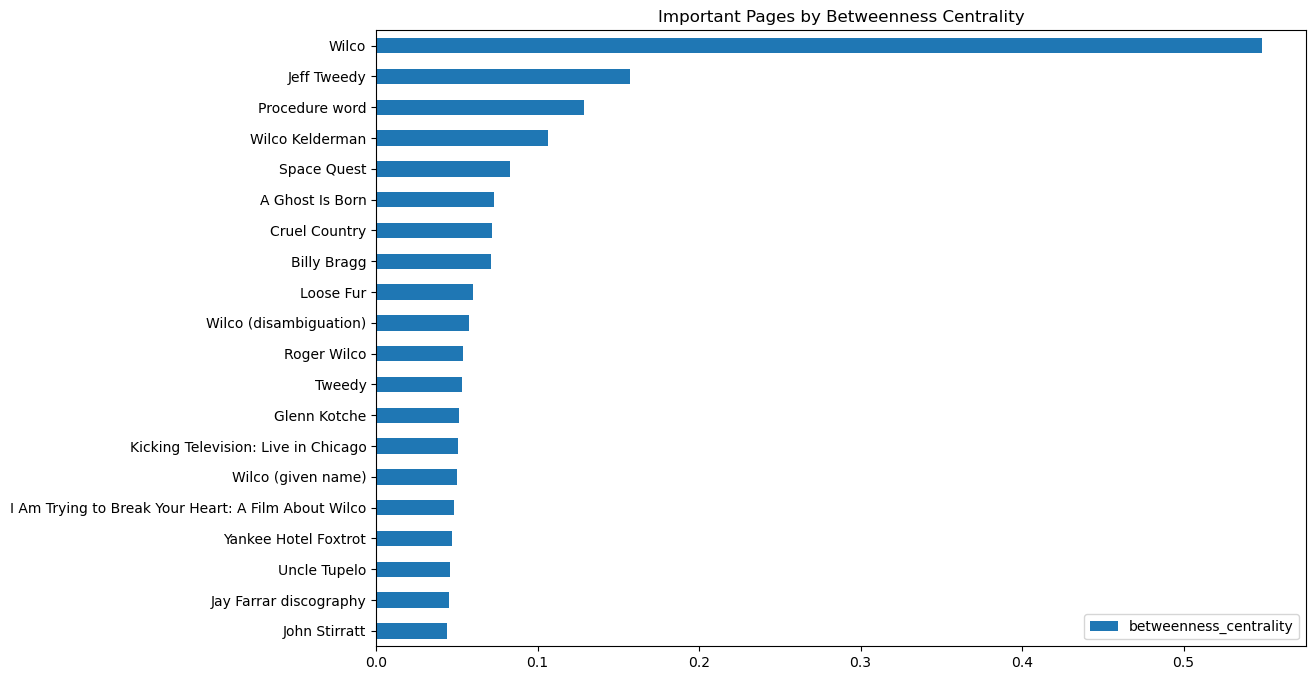

In [11]:
title = 'Important Pages by Betweenness Centrality'

betw_cent_df.head(20).plot.barh(figsize=(12,8), title=title).invert_yaxis()

# Jeff Tweedy, Billy Bragg, Roger Wilco, Tweedy, Glenn Kotche, Jay Farrar, Uncle Tupelo, John Stirratt - Who/What are they?

# Community Detection

We have one large connected component, and this will be great for use in Community Detection. The smaller connected components are communities of their own in this network, split off from the main piece of this network.

In [12]:
def draw_partition(G, partition): 

    import matplotlib.cm as cm 
    import matplotlib.pyplot as plt 

    # draw the graph 
    plt.figure(3,figsize=(12,12)) 
    pos = nx.spring_layout(G) 

    # color the nodes according to their partition 
    cmap = cm.get_cmap('jet', max(partition.values()) + 1) 
    nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=40, cmap=cmap, node_color=list(partition.values())) 
    nx.draw_networkx_edges(G, pos, alpha=0.5, width=0.3) 

    return plt.show() 

In [13]:
# identify communities; set resolution to 0.01 for smaller groups and 1 for larger groups, etc
# play with the number to get communities to the size you want them, or leave it at the default

partition = community_louvain.best_partition(G, resolution=0.5, random_state=1337) 

C:\Users\itsgo\AppData\Local\Temp\ipykernel_18692\2878357847.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('jet', max(partition.values()) + 1)


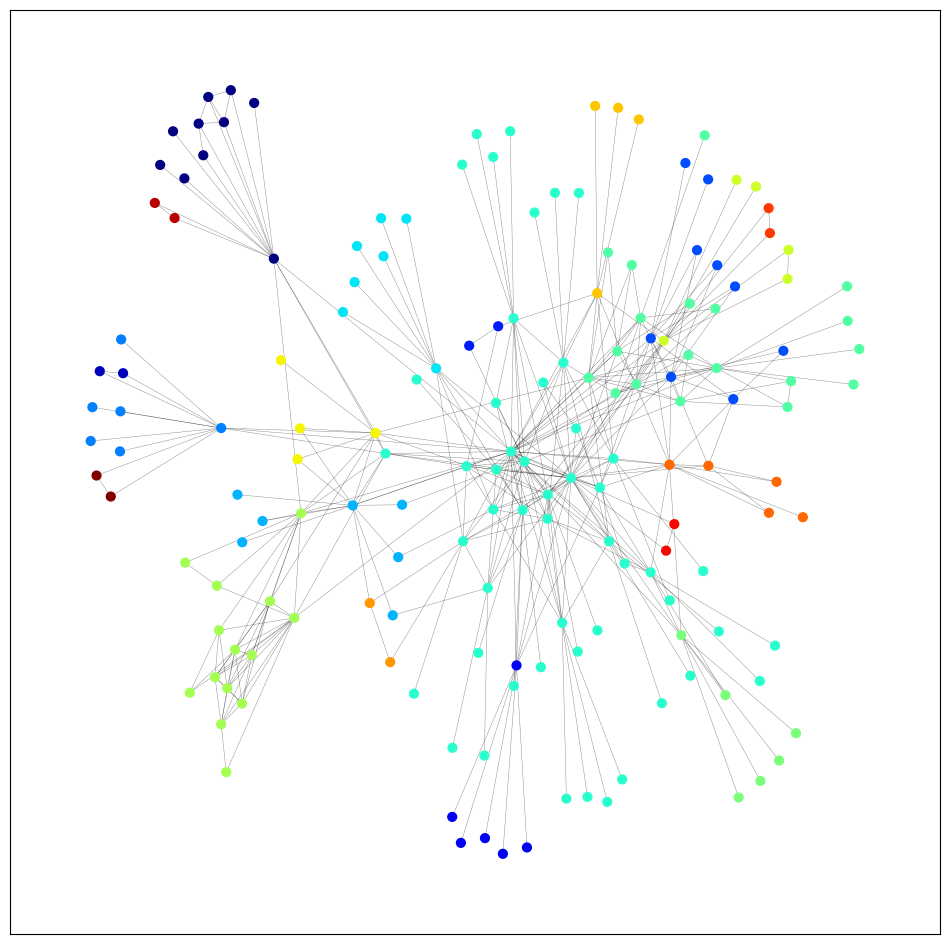

In [14]:
draw_partition(G, partition)

In [15]:
community_df = pd.DataFrame().from_dict(partition, orient='index')
community_df.reset_index(inplace=True)
community_df.columns = ['node', 'community']

# remove junk; identify relevant communities

community_df['community'].value_counts()[0:20]

community
8     50
9     19
11    14
0     10
4      9
6      7
7      7
2      6
10     6
5      6
16     5
12     5
14     4
13     4
20     2
17     2
15     2
19     2
18     2
3      2
Name: count, dtype: int64

In [16]:
comm_idx = community_df['community'].value_counts()[0:20].index.values
comm_idx

array([ 8,  9, 11,  0,  4,  6,  7,  2, 10,  5, 16, 12, 14, 13, 20, 17, 15,
       19, 18,  3], dtype=int64)

## Exploring Communities
Below, I am showing the largest community in the network. Looking at some of the node labels, I can see many instances of the word "graph". We are in the right place. 

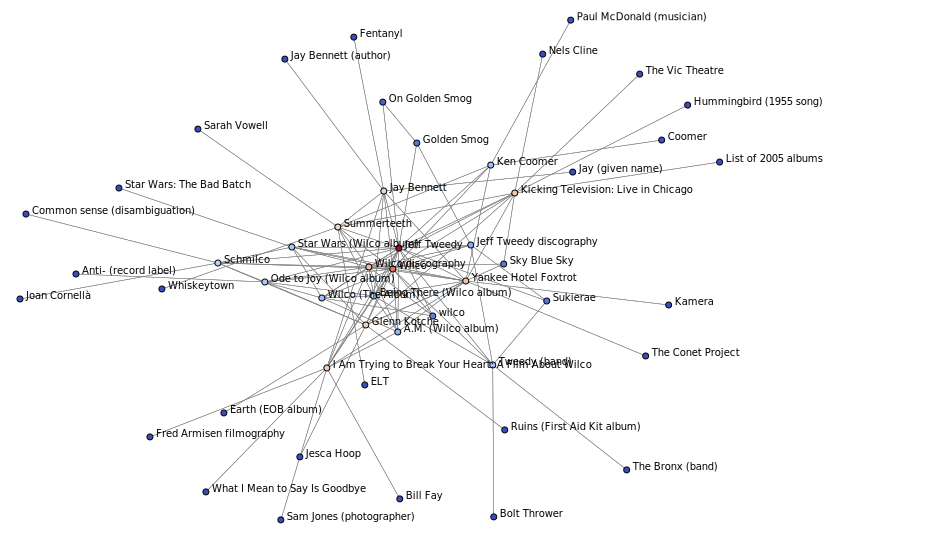

In [17]:
nodes = community_df[community_df['community']==comm_idx[0]]['node'].values

G_comm = G.subgraph(nodes)
G_net_main = G_comm.copy() # we will run community detection off of this at the end

draw_graph(nx.k_core(G_comm, 1), show_names=True, node_size=3)

In [18]:
netsci_nodes = [n for n in sorted(G_net_main.nodes)]
[print(n) for n in netsci_nodes]

A.M. (Wilco album)
Anti- (record label)
Being There (Wilco album)
Bill Fay
Bolt Thrower
Common sense (disambiguation)
Coomer
ELT
Earth (EOB album)
Fentanyl
Fred Armisen filmography
Glenn Kotche
Golden Smog
Hummingbird (1955 song)
I Am Trying to Break Your Heart: A Film About Wilco
Jay (given name)
Jay Bennett
Jay Bennett (author)
Jeff Tweedy
Jeff Tweedy discography
Jesca Hoop
Joan Cornellà
Kamera
Ken Coomer
Kicking Television: Live in Chicago
List of 2005 albums
Nels Cline
Ode to Joy (Wilco album)
On Golden Smog
Paul McDonald (musician)
Ruins (First Aid Kit album)
Sam Jones (photographer)
Sarah Vowell
Schmilco
Sky Blue Sky
Star Wars (Wilco album)
Star Wars: The Bad Batch
Sukierae
Summerteeth
The Bronx (band)
The Conet Project
The Vic Theatre
Tweedy (band)
What I Mean to Say Is Goodbye
Whiskeytown
Wilco
Wilco (The Album)
Wilco discography
Yankee Hotel Foxtrot
wilco


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

## More Communities!

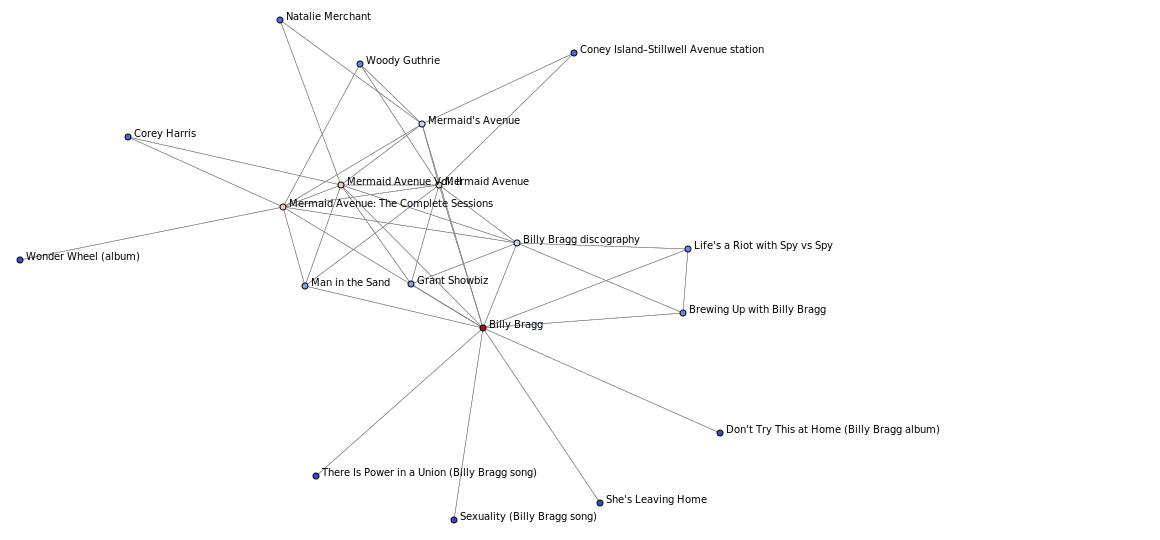

In [19]:
nodes = community_df[community_df['community']==comm_idx[1]]['node'].values

G_comm = G.subgraph(nodes)

draw_graph(nx.k_core(G_comm, 1), show_names=True, node_size=3)

In [20]:
[print(n) for n in sorted(G_comm.nodes)]

Billy Bragg
Billy Bragg discography
Brewing Up with Billy Bragg
Coney Island–Stillwell Avenue station
Corey Harris
Don't Try This at Home (Billy Bragg album)
Grant Showbiz
Life's a Riot with Spy vs Spy
Man in the Sand
Mermaid Avenue
Mermaid Avenue Vol. II
Mermaid Avenue: The Complete Sessions
Mermaid's Avenue
Natalie Merchant
Sexuality (Billy Bragg song)
She's Leaving Home
There Is Power in a Union (Billy Bragg song)
Wonder Wheel (album)
Woody Guthrie


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

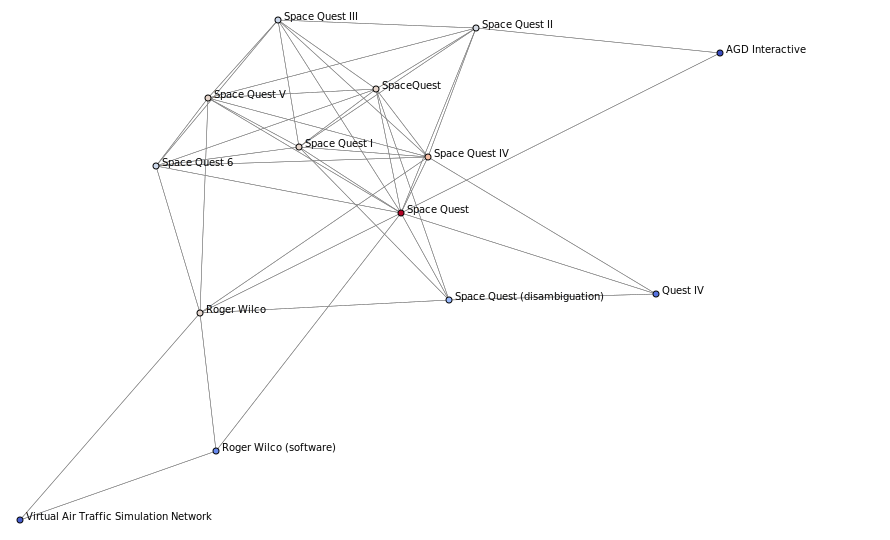

In [21]:
nodes = community_df[community_df['community']==comm_idx[2]]['node'].values

G_comm = G.subgraph(nodes)

draw_graph(nx.k_core(G_comm, 1), show_names=True, node_size=3)

In [22]:
[print(n) for n in sorted(G_comm.nodes)]

AGD Interactive
Quest IV
Roger Wilco
Roger Wilco (software)
Space Quest
Space Quest (disambiguation)
Space Quest 6
Space Quest I
Space Quest II
Space Quest III
Space Quest IV
Space Quest V
SpaceQuest
Virtual Air Traffic Simulation Network


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

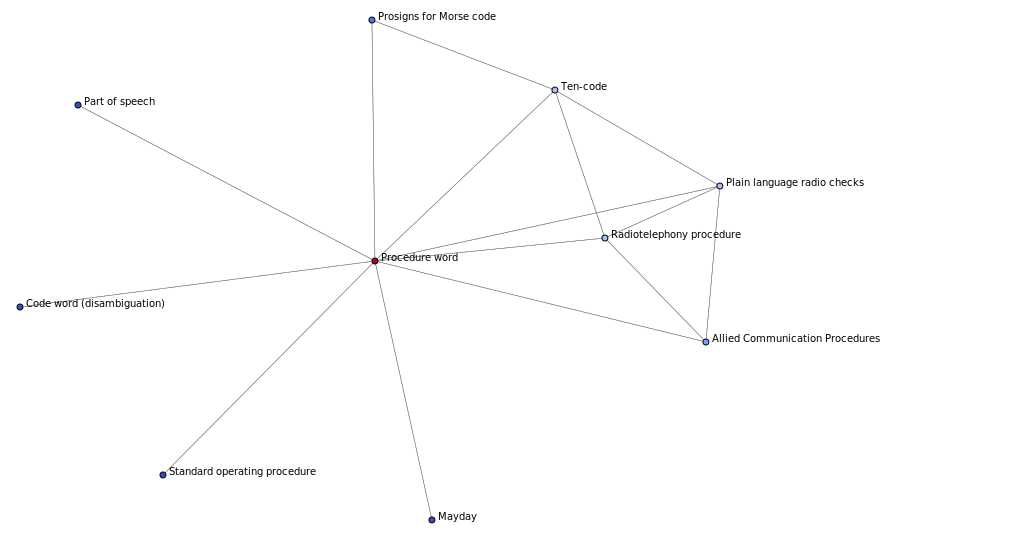

In [23]:
nodes = community_df[community_df['community']==comm_idx[3]]['node'].values

G_comm = G.subgraph(nodes)

draw_graph(nx.k_core(G_comm, 1), show_names=True, node_size=3)

In [24]:
[print(n) for n in sorted(G_comm.nodes)]

Allied Communication Procedures
Code word (disambiguation)
Mayday
Part of speech
Plain language radio checks
Procedure word
Prosigns for Morse code
Radiotelephony procedure
Standard operating procedure
Ten-code


[None, None, None, None, None, None, None, None, None, None]

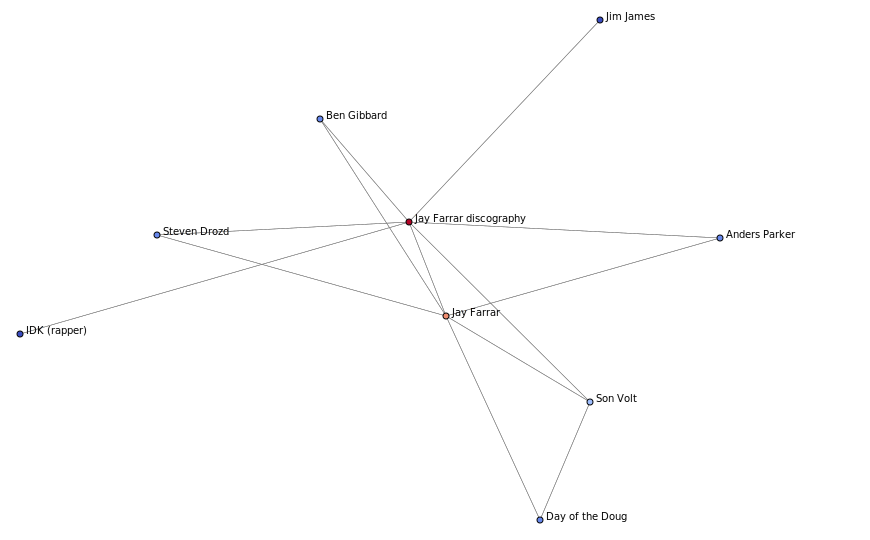

In [25]:
nodes = community_df[community_df['community']==comm_idx[4]]['node'].values

G_comm = G.subgraph(nodes)

draw_graph(nx.k_core(G_comm, 1), show_names=True, node_size=3)

In [26]:
[print(n) for n in sorted(G_comm.nodes)]

Anders Parker
Ben Gibbard
Day of the Doug
IDK (rapper)
Jay Farrar
Jay Farrar discography
Jim James
Son Volt
Steven Drozd


[None, None, None, None, None, None, None, None, None]

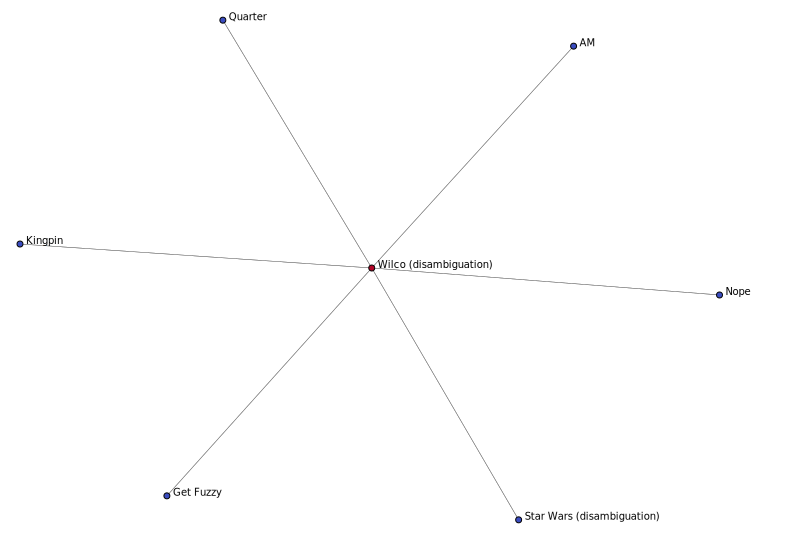

In [27]:
nodes = community_df[community_df['community']==comm_idx[5]]['node'].values

G_comm = G.subgraph(nodes)

draw_graph(nx.k_core(G_comm, 1), show_names=True, node_size=3)

In [28]:
[print(n) for n in sorted(G_comm.nodes)]

AM
Get Fuzzy
Kingpin
Nope
Quarter
Star Wars (disambiguation)
Wilco (disambiguation)


[None, None, None, None, None, None, None]

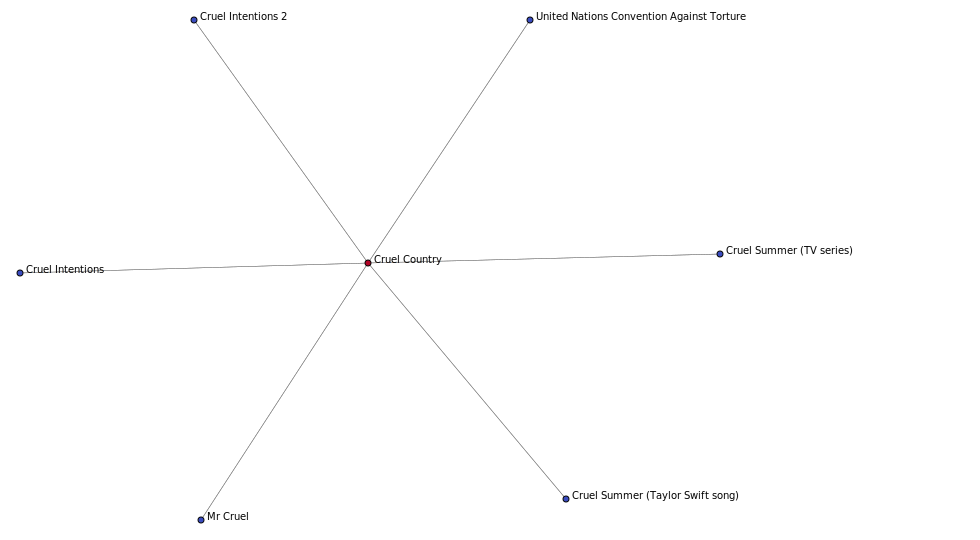

In [29]:
nodes = community_df[community_df['community']==comm_idx[6]]['node'].values

G_comm = G.subgraph(nodes)

draw_graph(nx.k_core(G_comm, 1), show_names=True, node_size=3)

In [30]:
[print(n) for n in sorted(G_comm.nodes)]

Cruel Country
Cruel Intentions
Cruel Intentions 2
Cruel Summer (TV series)
Cruel Summer (Taylor Swift song)
Mr Cruel
United Nations Convention Against Torture


[None, None, None, None, None, None, None]

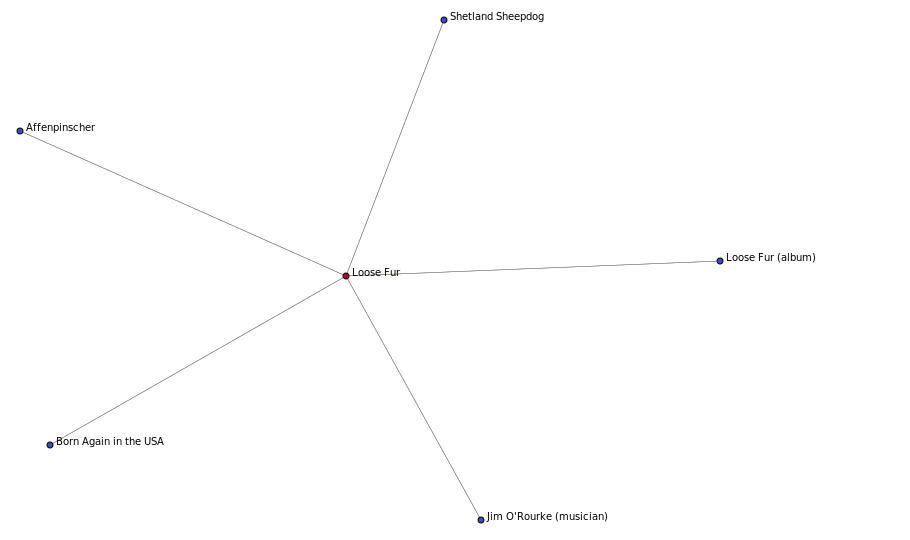

In [31]:
nodes = community_df[community_df['community']==comm_idx[7]]['node'].values

G_comm = G.subgraph(nodes)

draw_graph(nx.k_core(G_comm, 1), show_names=True, node_size=3)

In [32]:
[print(n) for n in sorted(G_comm.nodes)]

Affenpinscher
Born Again in the USA
Jim O'Rourke (musician)
Loose Fur
Loose Fur (album)
Shetland Sheepdog


[None, None, None, None, None, None]

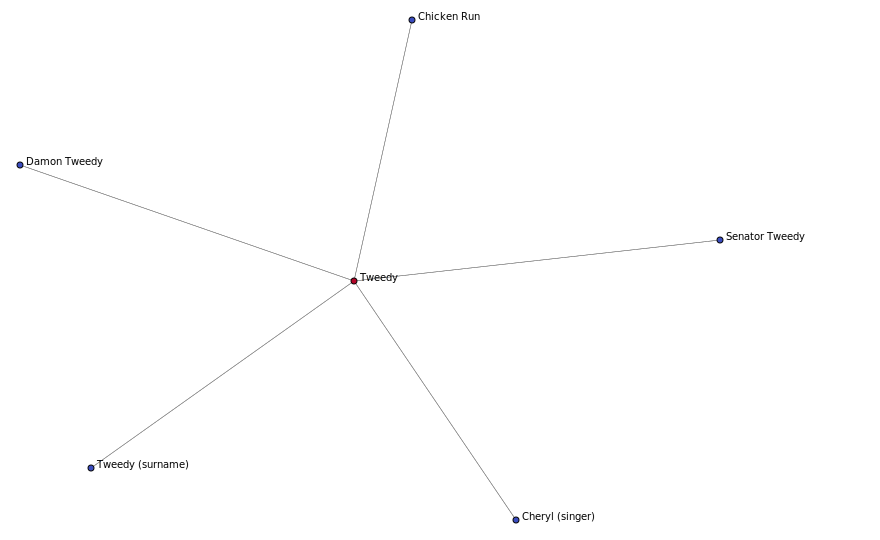

In [33]:
nodes = community_df[community_df['community']==comm_idx[8]]['node'].values

G_comm = G.subgraph(nodes)

draw_graph(nx.k_core(G_comm, 1), show_names=True, node_size=3)

In [34]:
[print(n) for n in sorted(G_comm.nodes)]

Cheryl (singer)
Chicken Run
Damon Tweedy
Senator Tweedy
Tweedy
Tweedy (surname)


[None, None, None, None, None, None]

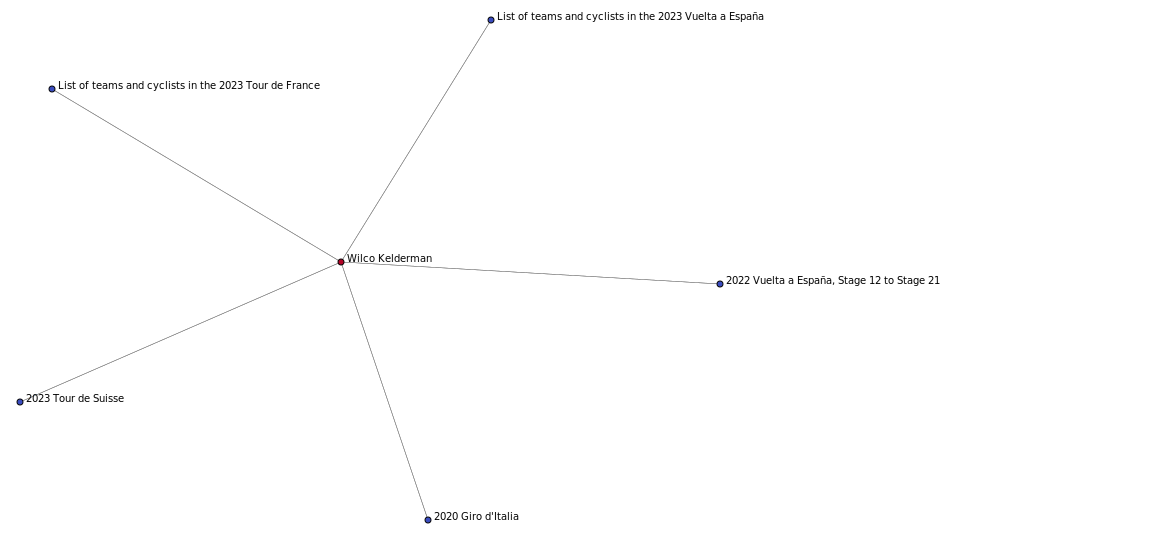

In [35]:
nodes = community_df[community_df['community']==comm_idx[9]]['node'].values

G_comm = G.subgraph(nodes)

draw_graph(nx.k_core(G_comm, 1), show_names=True, node_size=3)

# Ego Networks

Ego Networks are very useful for seeing what nodes exists around a node of interest, and how they are connected. In this dataset, there is a lot of cross-linking from alter nodes (the outer nodes), so we have interesting ego networks to look at. This is not always the case, so it is nice.

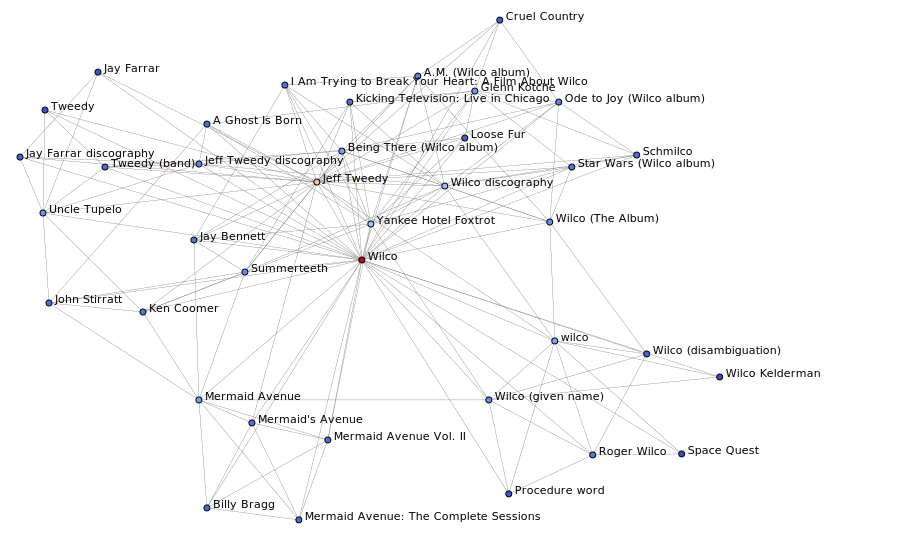

In [36]:
ego = nx.ego_graph(G, 'Wilco')

draw_graph(ego, show_names=True, node_size=3, font_size=11, edge_width=0.2)

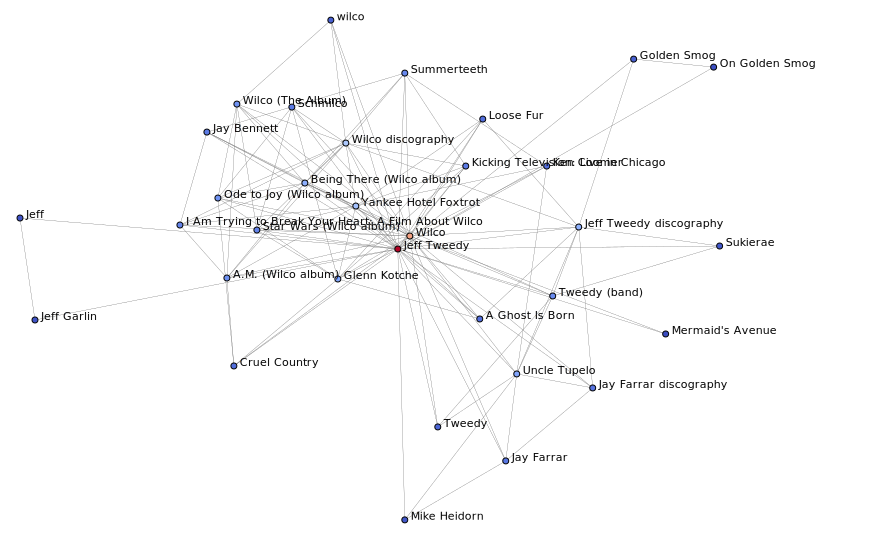

In [37]:
ego = nx.ego_graph(G, 'Jeff Tweedy')

draw_graph(ego, show_names=True, node_size=3, font_size=11, edge_width=0.2)

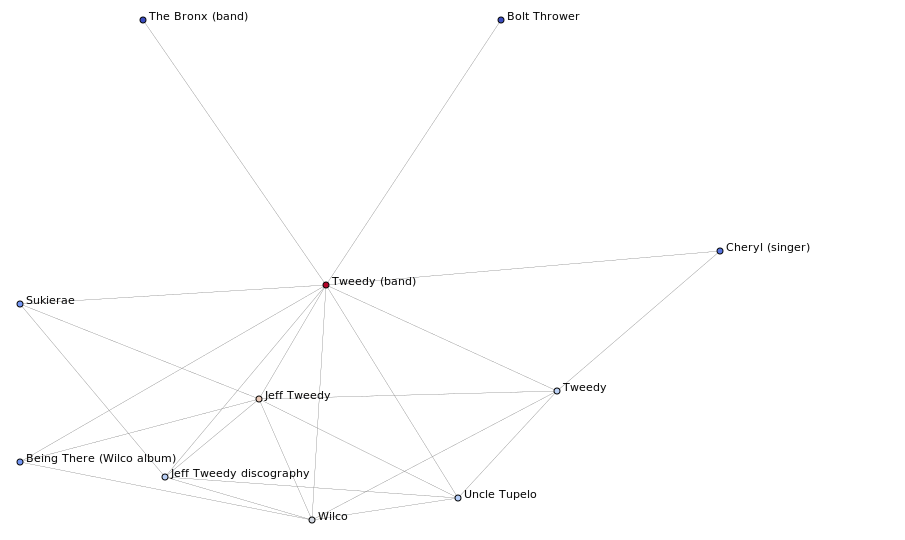

In [38]:
ego = nx.ego_graph(G, 'Tweedy (band)')

draw_graph(ego, show_names=True, node_size=3, font_size=11, edge_width=0.2)

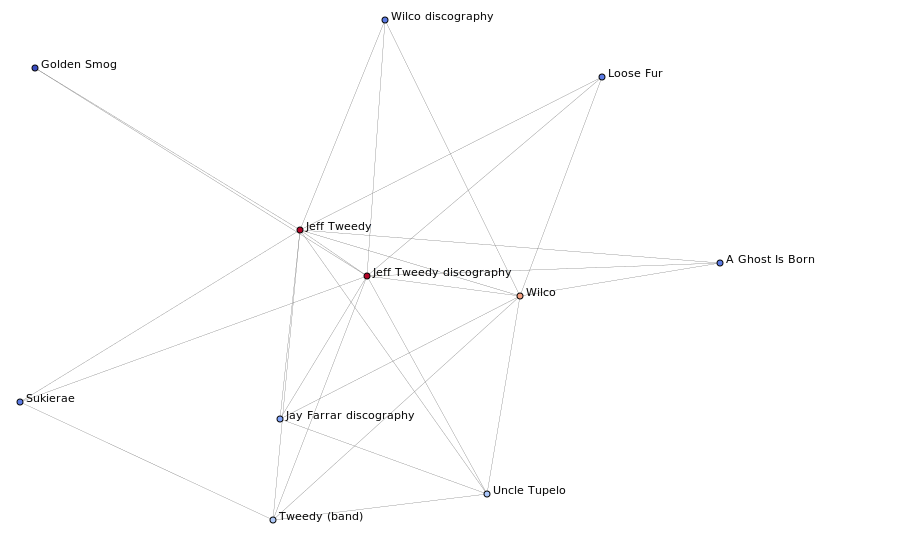

In [39]:
ego = nx.ego_graph(G, 'Jeff Tweedy discography')

draw_graph(ego, show_names=True, node_size=3, font_size=11, edge_width=0.2)

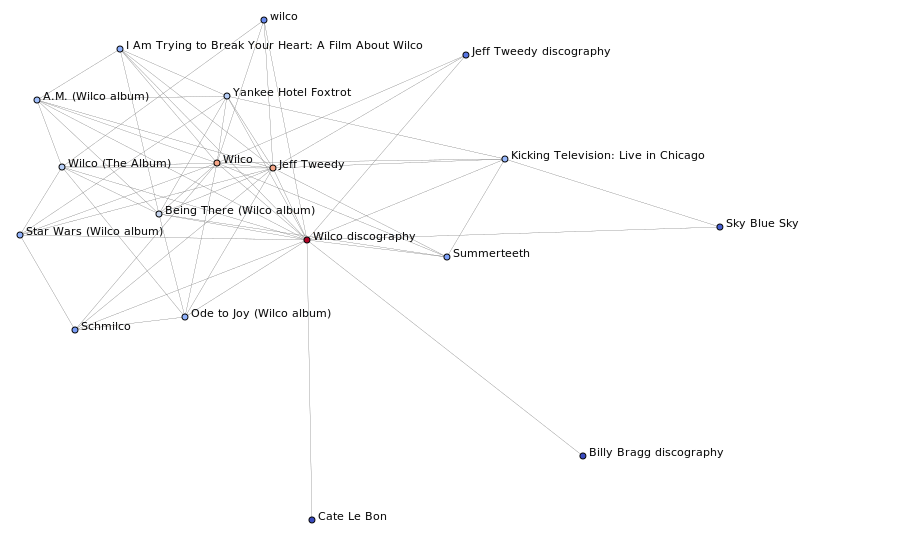

In [40]:
ego = nx.ego_graph(G, 'Wilco discography')

draw_graph(ego, show_names=True, node_size=3, font_size=11, edge_width=0.2)